In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import euclidean_distances
%matplotlib inline

In [2]:
#Reading feature vector 
X = pd.read_csv('./amp_ad_rna_seq_feature_set.csv')

In [3]:
#Dropping GeneID column 
GeneId = X['GeneID']
X = X.drop(['GeneID'], axis = 1)
X.head()

,DLPFCdegree,DLPFCauthority_score,DLPFCcloseness,DLPFCeccentricity,DLPFCcentr_betw,DLPFCpagerank,TCXdegree,TCXauthority_score,TCXcloseness,TCXeccentricity,...,aggregateTCXturquoiseTCXcloseness,aggregateTCXturquoiseTCXeccentricity,aggregateTCXturquoiseTCXcentr_betw,aggregateTCXturquoiseTCXpagerank,aggregateTCXyellowTCXdegree,aggregateTCXyellowTCXauthority_score,aggregateTCXyellowTCXcloseness,aggregateTCXyellowTCXeccentricity,aggregateTCXyellowTCXcentr_betw,aggregateTCXyellowTCXpagerank
0,22,0.000579,3.127838e-08,9,22475.492836,0.000104,17,4.863454e-05,2.250450e-08,11,...,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0
1,8,0.000002,3.127567e-08,9,13576.287523,0.000055,0,0.000000e+00,3.459190e-09,0,...,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0
2,4,0.000003,3.126776e-08,9,2826.000108,0.000042,6,4.563337e-08,2.249767e-08,11,...,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0
3,22,0.015326,3.127614e-08,9,12611.714094,0.000089,20,2.637571e-02,2.250408e-08,11,...,0.000007,6,1329.080162,0.001071,0,0.0,0.0,0,0.0,0.0
4,27,0.022256,3.127683e-08,9,33233.304215,0.000110,20,4.422801e-03,2.250222e-08,12,...,0.000007,6,1316.848500,0.001115,0,0.0,0.0,0,0.0,0.0


In [4]:
#Reading response vector 
Y = pd.read_excel('./ResponseVec_040318.xlsx')
Y = Y.drop(['GeneID'], axis = 1)
Y.head()

,Y
0,0
1,0
2,0
3,0
4,0


In [5]:
#Performing dimensionality reduction using PCA to 2 dimensions 
pca = PCA(n_components=20)
X_normed = X.values / X.values.max(axis=0)
pca.fit(X_normed)
X_pca = pca.fit_transform(X_normed)

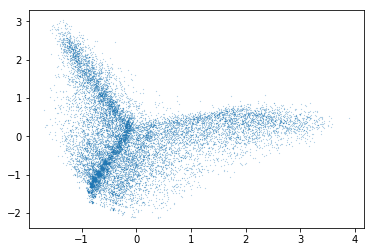

In [6]:
#Visualizing low dimensionality data using PCA 
plt.scatter(X_pca[:,0],X_pca[:,1], s = .5**6)

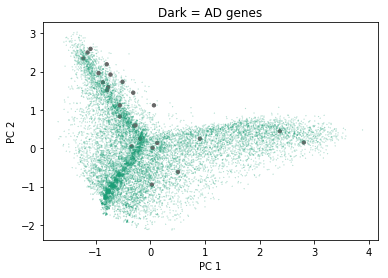

In [7]:
#Coloring the known AD related genes differently 
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

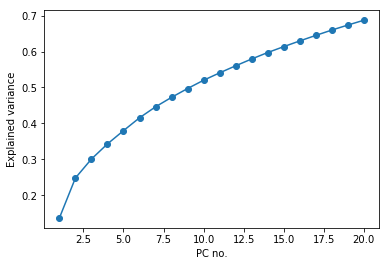

In [8]:
#Looking at variance explained by PC's 
s = 0 
PCA_ExpVar = []
for i in range(len(pca.explained_variance_ratio_)):
    s += pca.explained_variance_ratio_[i]
    PCA_ExpVar += [s]
    
plt.plot(xrange(1,len(PCA_ExpVar)+1),PCA_ExpVar,marker = 'o')
plt.xlabel('PC no.')
plt.ylabel('Explained variance')

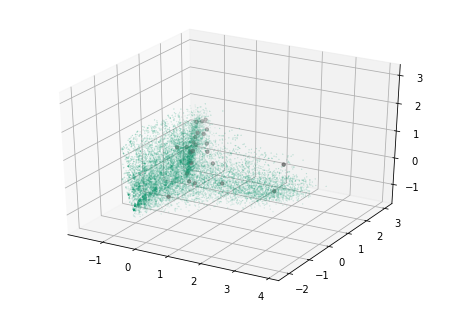

In [9]:
#Plotting the top 3 PCA components 
ax = Axes3D(plt.gcf())
ax.scatter(X_pca[:,0],X_pca[:,1],zs = X_pca[:,2],
           c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')

In [10]:
#Writing code to remove non-variant genes 
def max_variance_genes(data, nbins=5, frac=0.2):
    """
    This function identifies the genes that have the max variance
    across a number of bins sorted by mean.

    Args:
        data (array): genes x cells
        nbins (int): number of bins to sort genes by mean expression level. Default: 10.
        frac (float): fraction of genes to return per bin - between 0 and 1. Default: 0.1

    Returns:
        list of gene indices (list of ints)
    """
    indices = []
    means = data.mean(1)
    if sparse.issparse(data):
        var = sparse_var(data)
        means = np.array(means).flatten()
    else:
        var = data.var(1)
    mean_indices = means.argsort()
    n_elements = int(data.shape[0]/nbins)
    frac_elements = int(n_elements*frac)
    for i in range(nbins):
        bin_i = mean_indices[i*n_elements : (i+1)*n_elements]
        if i==nbins-1:
            bin_i = mean_indices[i*n_elements :]
        var_i = var[bin_i]
        var_sorted = var_i.argsort()
        top_var_indices = var_sorted[len(bin_i) - frac_elements:]
        ind = bin_i[top_var_indices]
        # filter out genes with zero variance
        ind = [index for index in ind if var[index]>0]
        indices.extend(ind)
    return indices
    

In [ ]:
#Performing tSNE 
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity= 250)
X_tsne = tsne.fit_transform(X_normed)

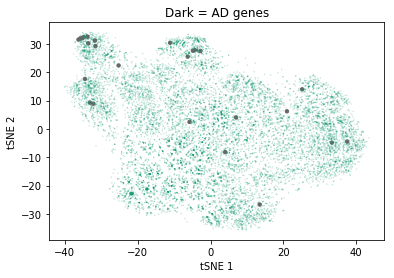

In [133]:
plt.scatter(X_tsne[:,0],X_tsne[:,1], c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('tSNE 1') 
plt.ylabel('tSNE 2')

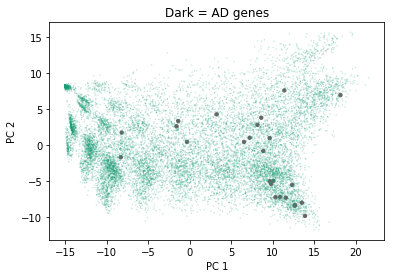

In [126]:
pca = PCA(n_components=20)
pca.fit(np.log(1 + X.values))
X_pca = pca.fit_transform(np.log(1 + X.values))
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

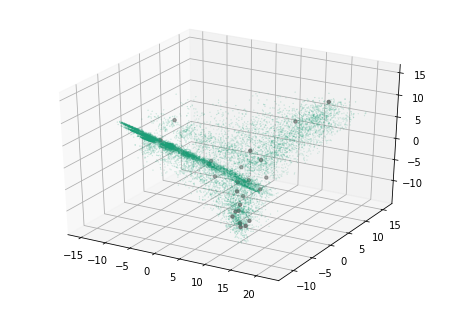

In [127]:
ax = Axes3D(plt.gcf())
ax.scatter(X_pca[:,0],X_pca[:,1],zs = X_pca[:,2],
           c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')

In [ ]:
#Performing logistic regression with k-fold cross validaiton 
L_Cv = LogisticRegressionCV(Cs = 10, cv=10, penalty='l2',solver = 'lbfgs')
L_Cv.fit(X_normed, Y.values)
Y_pred = L_Cv.predict_proba(X_normed)

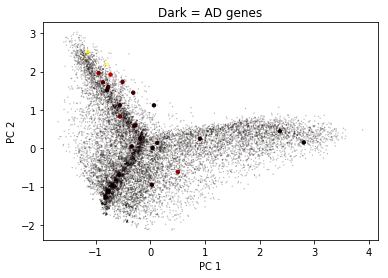

In [40]:
#Coloring PCs based on predicted probabilities sized by known 
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y_pred[:,1] , s =(Y.values+.5)**6, cmap = 'hot')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

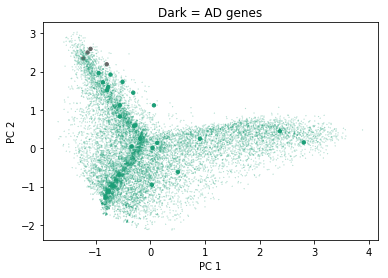

In [41]:
#Coloring PCs based on predicted probabilities sized by known AD genes
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y_pred[:,1]>.5 , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

In [43]:
#Cell classified performance 
L_Cv.score(X_normed, Y.values)

0.99854651162790697

In [12]:
#Balancing classes for better classification performance 
In = np.argwhere(Y.values)
In = In[:,0]
X_new = X_normed
Reps = 500
Y_new = Y.values
for i in range(Reps):
    X_new = np.vstack((X_new,X_normed[In]))
    Y_new = np.vstack((Y_new,np.ones((len(In),1))))
print X_new.shape
print Y_new.shape

(26948, 348)
(26948, 1)


In [17]:
#Performing logistic regression with k-fold cross validaiton on balanced classes 
L_Cv = LogisticRegressionCV(Cs = 10, cv=10, penalty='l2',solver = 'saga')
L_Cv.fit(X_new, Y_new)
Y_pred = L_Cv.predict_proba(X_normed)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [16]:
#Cell classified performance 
L_Cv.C_

array([ 10000.])

In [23]:
L_Cv.

(10, 10, 349)

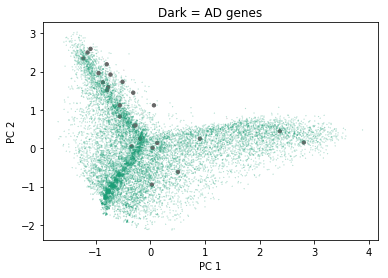

In [170]:
#Coloring PCs based on predicted probabilities sized by known AD genes
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y_pred[:,1]>.5 , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

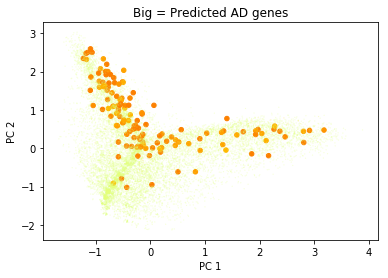

In [171]:
#Coloring PCs based on predicted probabilities sized by known AD genes
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y_pred[:,1] , s =(20*(Y_pred[:,1]>0.5)+.01), cmap = 'Wistia')
plt.title('Big = Predicted AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

In [172]:
#Getting the GeneID's of the predicted regulator genes
bla = np.argwhere(Y_pred[:,1]>0.5)
GenePred = GeneId[bla[:,0]]
print GenePred

97       ENSG00000006042
177      ENSG00000008838
249      ENSG00000011600
319      ENSG00000019582
527      ENSG00000048028
749      ENSG00000064687
818      ENSG00000066336
898      ENSG00000068831
899      ENSG00000068878
1053     ENSG00000073712
1058     ENSG00000073921
1081     ENSG00000074660
1192     ENSG00000078061
1270     ENSG00000080815
1289     ENSG00000081189
1374     ENSG00000084234
1687     ENSG00000094975
1716     ENSG00000095970
1753     ENSG00000099337
1871     ENSG00000100292
1906     ENSG00000100379
1956     ENSG00000100599
2056     ENSG00000101194
2163     ENSG00000101977
2215     ENSG00000102468
2533     ENSG00000105281
2613     ENSG00000105722
2670     ENSG00000106100
2761     ENSG00000106976
2906     ENSG00000108518
              ...       
10655    ENSG00000178445
10717    ENSG00000179083
10742    ENSG00000179344
10898    ENSG00000181163
10929    ENSG00000181631
10973    ENSG00000182141
11091    ENSG00000183077
11222    ENSG00000184144
11246    ENSG00000184271


In [ ]:
GenePred.to_csv('PredictedGenes_Logistic_L1.csv')

In [36]:
#Getting list of genes which have SNPs according to IGAP_stage1
cnt = 0 
GeneNames = []
MinPval = []
with open("E:/SageDocs/AMP-AD_Network_Analysis/IGAP_files/IGAP_geneAnalysis.genes.raw") as f:
    for line in f:
        if cnt <= 1:
            cnt+=1 
            continue
            
        cnt += 1
        temp = line.split(' ')

        if len(temp)>9:
            GeneNames += [temp[0]]
            temp = map(float,temp[9:])
            MinPval += [min(temp)]
        

(array([  2.00000000e+00,   4.00000000e+00,   1.80000000e+01,
          6.50000000e+01,   2.01400000e+03,   9.68500000e+03,
          5.42600000e+03,   4.84000000e+02,   6.70000000e+01,
          4.80000000e+01]),
 array([-8.15787587, -7.34406012, -6.53024438, -5.71642863, -4.90261288,
        -4.08879714, -3.27498139, -2.46116564, -1.6473499 , -0.83353415,
        -0.01971841]),
 <a list of 10 Patch objects>)

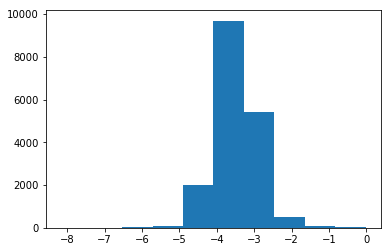

In [71]:
#Plotting distribution of p-values
plt.hist(np.log10(MinPval))

In [40]:
IGAP_genes = pd.DataFrame(data = {'Genes':GeneNames,'Pval':MinPval})
IGAP_genes.head()

,Genes,Pval
0,ISG15,0.710123
1,AGRN,0.679699
2,RNF223,0.340268
3,C1orf159,0.091718
4,TTLL10,0.003411


In [47]:
#Get the genes that are predicted regulators 
Dat = pd.read_excel('./PredGenes_Symb_L1_Logistic.xlsx')
for i in range(len(Dat['To'])):
    Dat['To'][i] = Dat['To'][i].upper()
    
Dat.head()

,From,To,Species,Gene Name
0,ENSG00000114978,MOBKL1B,Homo sapiens,"MOB1, Mps One Binder kinase activator-like 1B ..."
1,ENSG00000106100,NOD1,Homo sapiens,nucleotide-binding oligomerization domain cont...
2,ENSG00000073921,PICALM,Homo sapiens,phosphatidylinositol binding clathrin assembly...
3,ENSG00000133275,CSNK1G2,Homo sapiens,"casein kinase 1, gamma 2"
4,ENSG00000115107,STEAP3,Homo sapiens,STEAP family member 3


In [69]:
#Getting P-values of genes that have an
Int = list(set(Dat['To']).intersection(IGAP_genes['Genes']))

E = []
G = [] 
P = []

for i in range(len(Int)):
    In = IGAP_genes['Genes'][IGAP_genes['Genes']==Int[i]].index[0]
    In2 = Dat['To'][Dat['To']==Int[i]].index[0]
    G += [IGAP_genes['Genes'][In]]
    P += [IGAP_genes['Pval'][In]]
    E += [Dat['From'][In2]]
    
    
PredGenes_pval = pd.DataFrame(data = {'Ensebml':E,'GeneSymb':G,'Pval':P})
PredGenes_pval.head()

,Ensebml,GeneSymb,Pval
0,ENSG00000138434,SSFA2,0.000145
1,ENSG00000120899,PTK2B,0.000049
2,ENSG00000165379,LRFN5,0.000130
3,ENSG00000048028,USP28,0.000097
4,ENSG00000137821,LRRC49,0.000086


In [70]:
PredGenes_pval.to_csv('PredictedGenes_Logistic_L1_pval.csv')

(array([ 12.,  21.,  19.,  15.,  24.,  11.,   7.,   4.,   1.,   3.]),
 array([-4.36482198, -4.11910351, -3.87338504, -3.62766658, -3.38194811,
        -3.13622965, -2.89051118, -2.64479272, -2.39907425, -2.15335579,
        -1.90763732]),
 <a list of 10 Patch objects>)

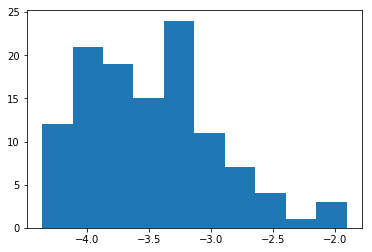

In [72]:
plt.hist(np.log10(P))